
# Loan Default Analysis & Prediction: A Quantitative Approach to Credit Risk Mitigation
**Introduction**

Lending institutions face a critical challenge: the risk of borrowers defaulting on loans. Every loan issued to a defaulter results in significant financial loss, making it essential to build systems that can distinguish between trustworthy borrowers and risky ones.

This project tackles that problem by analyzing public loan data from LendingClub (2007–2010), a peer-to-peer lending platform. The objective was to predict whether a borrower would default (not fully repay) their loan. In practical terms, the focus was on reducing false positives — avoiding the mistake of granting loans to borrowers who are likely to default.

To achieve this, we followed a structured methodology:

**Exploratory Data Analysis (EDA)**: Identified key risk factors such as credit score, loan purpose, and recent credit inquiries. Outliers and trends were explored to understand borrower behavior.

**Preprocessing** : Applied scaling to numerical features, one-hot encoding to categorical features, and handled imbalances in the target variable using SMOTE.

**Modeling**: Tested multiple models (Logistic Regression, Support Vector Machine, Random Forest, XGBoost) to compare performance, with a focus on precision as the evaluation metric.

**Insights**: Beyond prediction, we extracted business insights, highlighting which borrower characteristics are most predictive of default.

While the models showed promising results, particularly XGBoost, which achieved the best precision, the project also points to areas for further improvement through advanced feature engineering and optimization.


In [2]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Load the dataset

df = pd.read_csv("/content/drive/MyDrive/Loan Prediction dataset/loan_data.csv")
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


### **DATA EXPLORATION AND CLEANING.**



In [5]:
#Checking the quality of the dataset(Correct data types, no null values, etc)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


The dataset has 14 columns and 9578 rows.
It has no null values

Understanding the columns:

**Credit.policy**: if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.

**Purpose**: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational". The purpose of the loan is vital as it influences the loan's risk profile and the likelihood of repayment.

**int.rate:** The loan's interest rate represented as a proportion (e.g., 0.11 for 11%). Interest rates are pivotal as they reflect the lender's risk assessment—higher rates often correlate with perceived higher borrower risk.

**installment**: The monthly installment amount the borrower must pay if the loan is funded. Installments are significant as their size can impact the borrower's repayment capacity, especially relative to their income and other debts.

**log.annual.inc**: The natural logarithm of the borrower's self-reported annual income. Employing the logarithm reduces income distribution skewness, facilitating better modeling.

**dti**: The debt-to-income ratio, computed as debt divided by annual income. A higher DTI suggests that a large income portion is allocated to debt servicing, potentially affecting loan repayment.

**fico**: The FICO credit score, a critical measure of creditworthiness influencing loan approval and terms.

**days.with.cr.line**: The number of days the borrower has had a credit line, where longer histories might imply more financial reliability.

**revol.bal**: The borrower's unpaid balance at the credit cycle end, with higher balances possibly indicating financial strain.

**revol.util**: The rate at which the borrower utilizes their revolving credit line. Higher rates can signify elevated credit risk.

**inq.last.6mths**: The count of credit inquiries in the last six months, where more inquiries can suggest increased credit-seeking behavior and potential risk.

**delinq.2yrs**: Instances of being 30+ days late on payments in the past two years, reflecting on the borrower's reliability.

**pub.rec**: The count of derogatory public records like bankruptcy filings or tax liens, which can significantly impact creditworthiness.

**not.fully.paid**: The binary target variable indicating whether the loan was not fully repaid (1) or was (0). Our predictive modeling efforts focus on this outcome.






In [6]:
#Checking the summary statistics

numerical_summary = df.describe().transpose()

diverging_palette = sns.color_palette("coolwarm", as_cmap=True)

numerical_summary.style.background_gradient(cmap=diverging_palette)

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.000000,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000
int.rate,9578.000000,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,0.216400
installment,9578.000000,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,940.140000
log.annual.inc,9578.000000,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,14.528354
dti,9578.000000,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,29.960000
fico,9578.000000,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,827.000000
days.with.cr.line,9578.000000,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,17639.958330
revol.bal,9578.000000,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1207359.000000
revol.util,9578.000000,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,119.000000
inq.last.6mths,9578.000000,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,33.000000


In [7]:
#Checking for duplicates
duplicates = df[df.duplicated()]

print(duplicates)

Empty DataFrame
Columns: [credit.policy, purpose, int.rate, installment, log.annual.inc, dti, fico, days.with.cr.line, revol.bal, revol.util, inq.last.6mths, delinq.2yrs, pub.rec, not.fully.paid]
Index: []


There are no duplicate values in the dataset.

## **EXPLORATORY DATA ANALYSIS (EDA)**

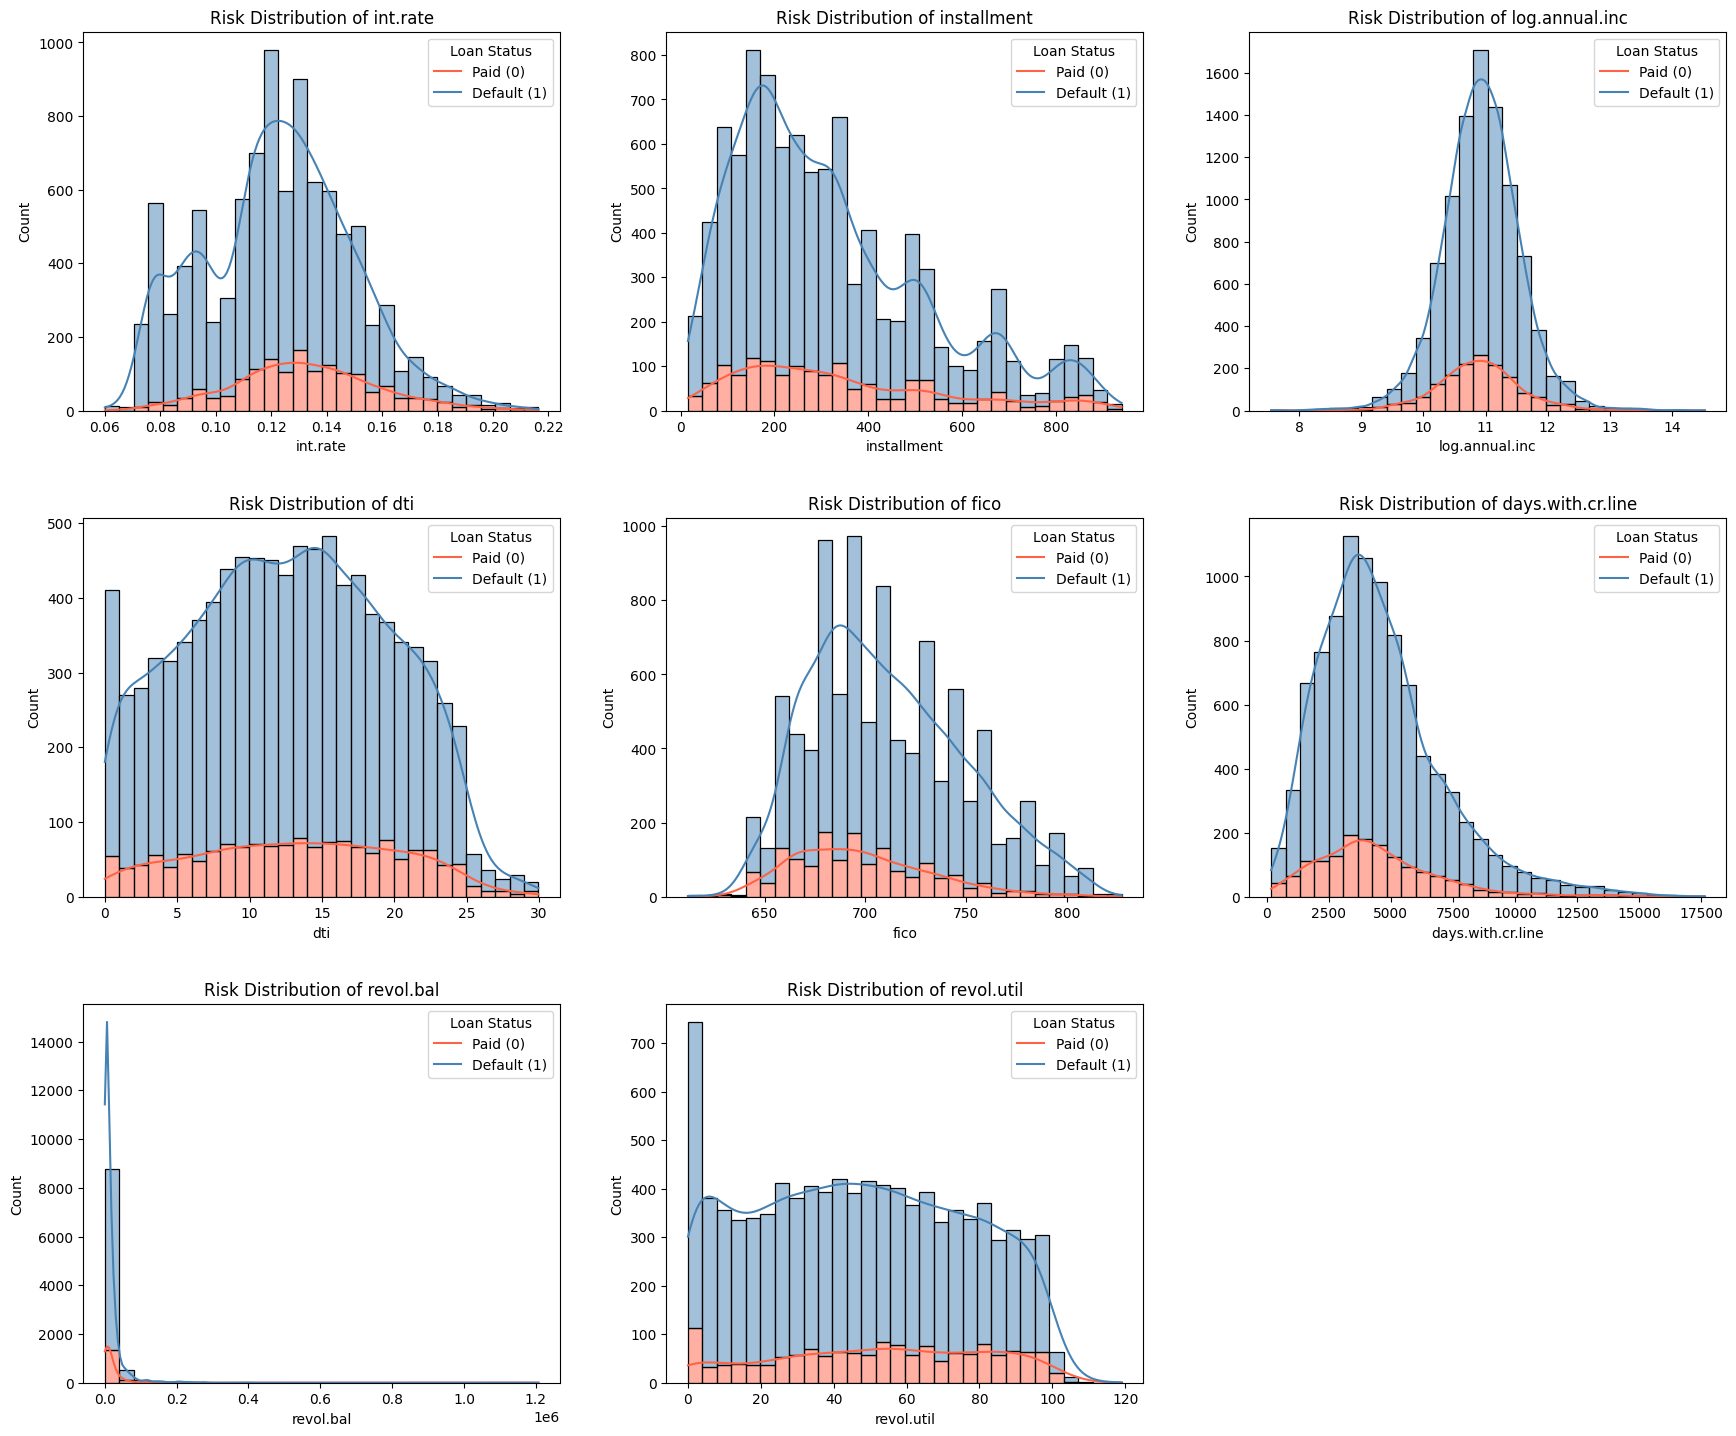

In [8]:
#Distribution of Variables
# Identify all numerical columns, excluding the target variable
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('not.fully.paid')

# Bivariate Histograms (Risk Profile Assessment)
risk_cols_hist = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
                  'days.with.cr.line', 'revol.bal', 'revol.util']

#3-column layout for the histograms (3 rows of 3, plus one extra row)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(risk_cols_hist):
    if i < len(risk_cols_hist):
        sns.histplot(data=df, x=col, hue='not.fully.paid', kde=True, ax=axes[i], bins=30,
                     multiple='stack', palette={0: 'steelblue', 1: 'tomato'})

        axes[i].set_title(f"Risk Distribution of {col}", fontsize=12)
        axes[i].legend(title='Loan Status', labels=['Paid (0)', 'Default (1)'])

# Hide unused subplots from the 3x3 grid
for j in range(len(risk_cols_hist), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()




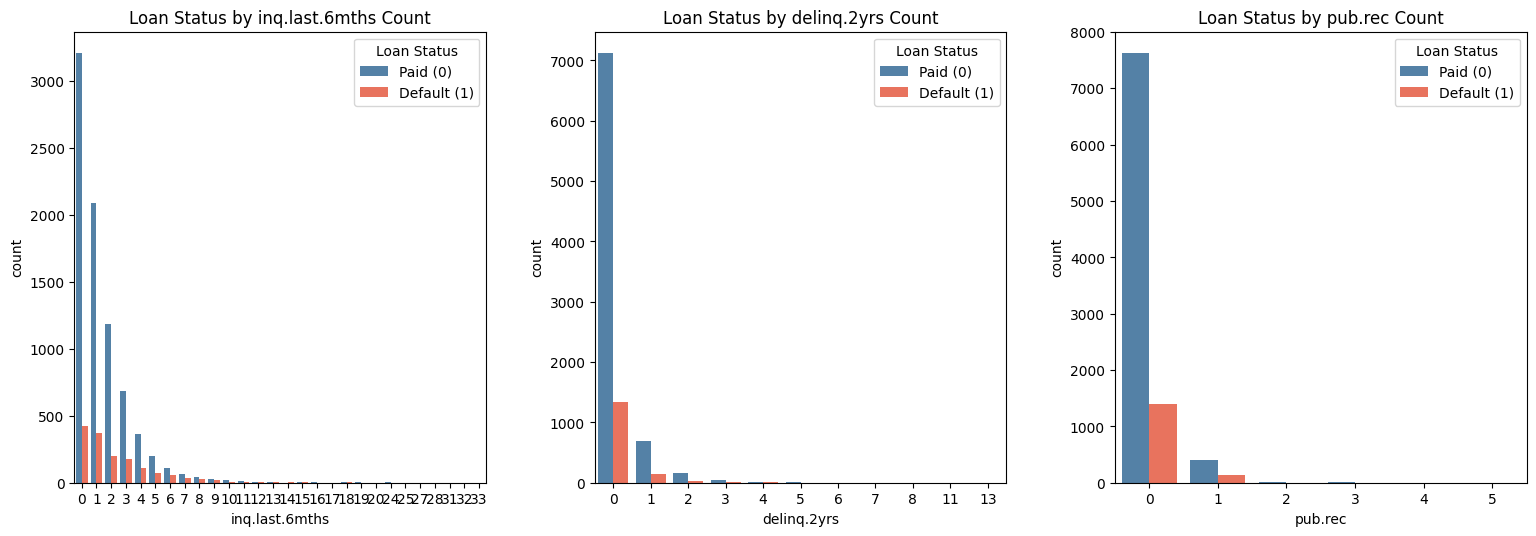

In [9]:
# Count Plots for Discrete/Sparse Risk Indicators (best viewed by count to emphasize the non-zero (risk) events.)
risk_cols_count = ['inq.last.6mths', 'delinq.2yrs', 'pub.rec']

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes = axes.flatten()

for i, col in enumerate(risk_cols_count):
    # Use Countplot to show the actual integer counts against the target variable
    sns.countplot(data=df, x=col, hue='not.fully.paid', ax=axes[i], palette={0: 'steelblue', 1: 'tomato'})
    axes[i].set_title(f"Loan Status by {col} Count", fontsize=12)
    axes[i].legend(title='Loan Status', labels=['Paid (0)', 'Default (1)'])

plt.tight_layout(pad=3.0)
plt.show()

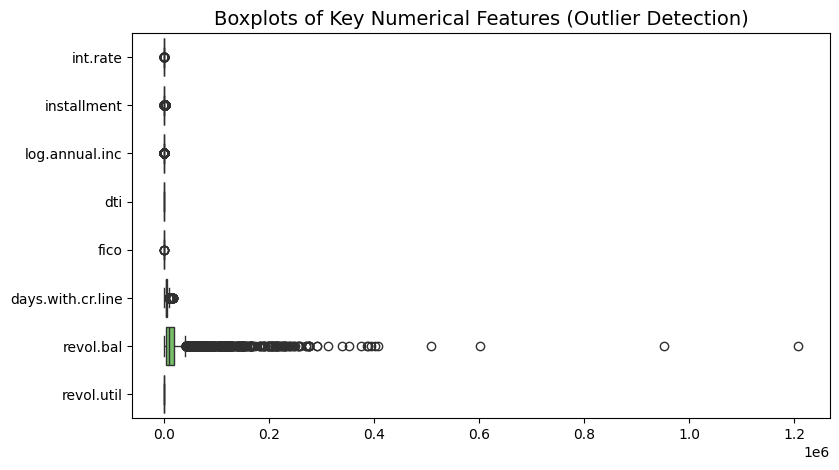

In [10]:
# Boxplots for Outlier Detection
plt.figure(figsize=(9, 5))
# Exclude highly discrete features for cleaner boxplot visualization
boxplot_cols = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
                'days.with.cr.line', 'revol.bal', 'revol.util']

sns.boxplot(data=df[boxplot_cols], orient="h", palette="viridis")
plt.title("Boxplots of Key Numerical Features (Outlier Detection)", fontsize=14)
plt.show()

In [18]:
# Define threshold: e.g., 99th percentile
threshold = df['revol.bal'].quantile(0.99)

# Number of outliers
outliers = df[df['revol.bal'] > threshold]
print(f"Outliers above 99th percentile: {outliers.shape[0]} ({100*len(outliers)/len(df):.2f}%)")

# Default rate among outliers
default_rate_outliers = outliers['not.fully.paid'].mean()
default_rate_all = df['not.fully.paid'].mean()

print(f"Default Rate (all borrowers): {default_rate_all:.2%}")
print(f"Default Rate (outliers): {default_rate_outliers:.2%}")


Outliers above 99th percentile: 96 (1.00%)
Default Rate (all borrowers): 16.01%
Default Rate (outliers): 33.33%


### Insights from Outlier Analysis (revol.bal)

After exploring extreme values in `revol.bal` (revolving balance) it was discovered that:
- Top 1% borrowers (balances > 99th percentile) showed a **default rate of 33.3%**,
  which is more than **double the population average of 16%**.  

## Interpretation:
Outliers are **informative signals** of credit risk.  
Borrowers with very high revolving balances are much riskier, so these values should not be removed.  

However, since the distribution is heavily skewed, we will apply a **log transformation** (`np.log1p`) to normalize the scale, while keeping the risk signal intact.


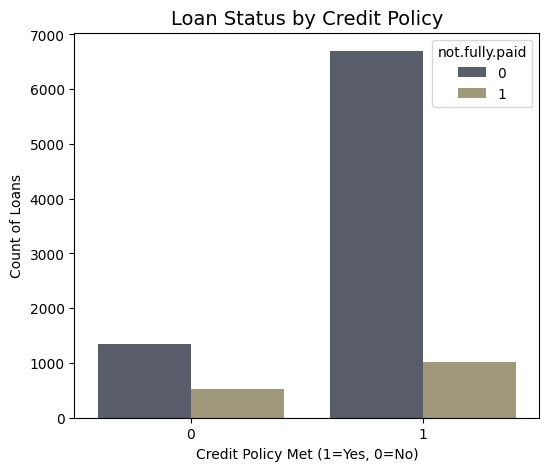

In [11]:
#Plot for Binary Feature (credit.policy)
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='credit.policy', hue='not.fully.paid', palette='cividis')
plt.title("Loan Status by Credit Policy", fontsize=14)
plt.xlabel("Credit Policy Met (1=Yes, 0=No)")
plt.ylabel("Count of Loans")
plt.show()

The distribution shows...

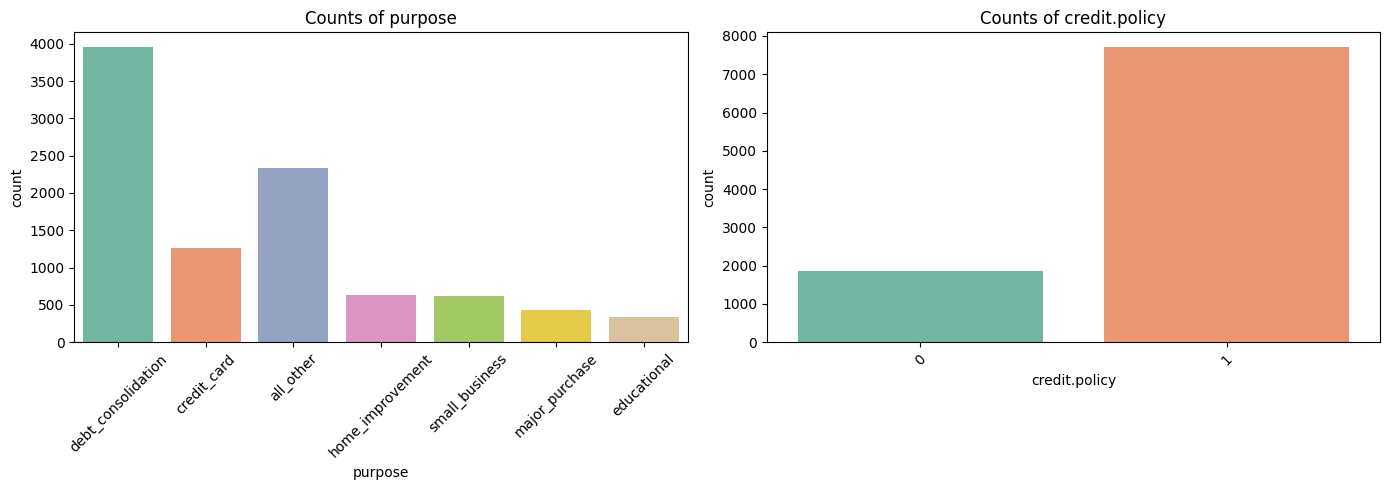

In [17]:
#plot to show the distribution of categorical features.
cat_cols = ['purpose', 'credit.policy']

fig, axes = plt.subplots(1, len(cat_cols), figsize=(14,5))

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"Counts of {col}")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Observations from Counts of purpose Plot

Dominant Category: The most common loan purpose by a significant margin is debt_consolidation. This accounts for well over one-third of all loans in the dataset.

Second Tier: The second and third most frequent purposes are credit_card and all_other (presumably a catch-all category for less common reasons).

Minor Categories: Purposes such as educational, major_purchase, small_business, and home_improvement are relatively infrequent, forming the long tail of the distribution.

# Observation from Counts of credit.policy Plot

Imbalance: The feature is heavily imbalanced. The number of loans that met the credit policy (1) is approximately 4 times greater than the number of loans that did not meet the policy (0).

Volume: The majority of the lending volume in the dataset complied with the policy.

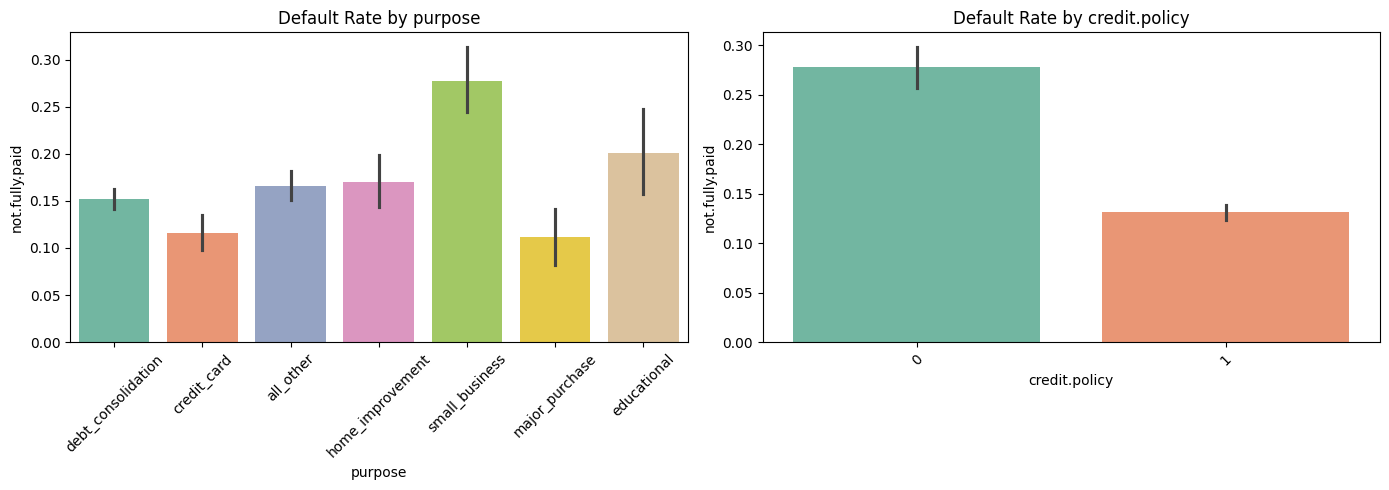

In [16]:
#Plot to show the default rate of categorical features
cat_cols = ['purpose', 'credit.policy']

fig, axes = plt.subplots(1, len(cat_cols), figsize=(14,5))

for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='not.fully.paid', data=df, ax=axes[i], palette="Set2", estimator=lambda x: sum(x)/len(x))
    axes[i].set_title(f"Default Rate by {col}")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Observations from default rate by purpose

Highest Risk Category: Loans taken for small_business have the highest average default rate, approaching 28%, significantly higher than any other category. (Note the large error bars, indicating less certainty due to lower sample size).

Second Highest Risk: educational loans also show a high default rate, around 20%.

Lowest Risk Categories: credit_card and major_purchase loans have the lowest default rates, both falling closer to 11%.

Most Common Loan (debt_consolidation): The default rate for the most common loan purpose, debt_consolidation, is moderate, around 15%.

# Observations from default rate by credit policy

This visual comparison clearly shows that the group failing the initial credit policy check is more than twice as likely to default compared to the group that passed. This confirms credit.policy is a strong indicator of risk.

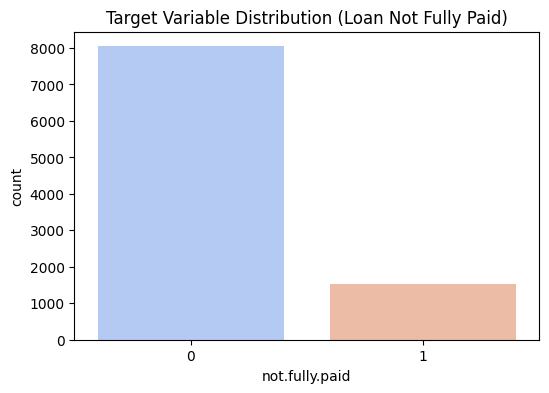

not.fully.paid
0    0.839946
1    0.160054
Name: proportion, dtype: float64


In [13]:
#Visualising the distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='not.fully.paid', data=df, palette="coolwarm")
plt.title("Target Variable Distribution (Loan Not Fully Paid)")
plt.show()

print(df['not.fully.paid'].value_counts(normalize=True))


The target is imbalanced hence we need to consider imbalance handling techniques.

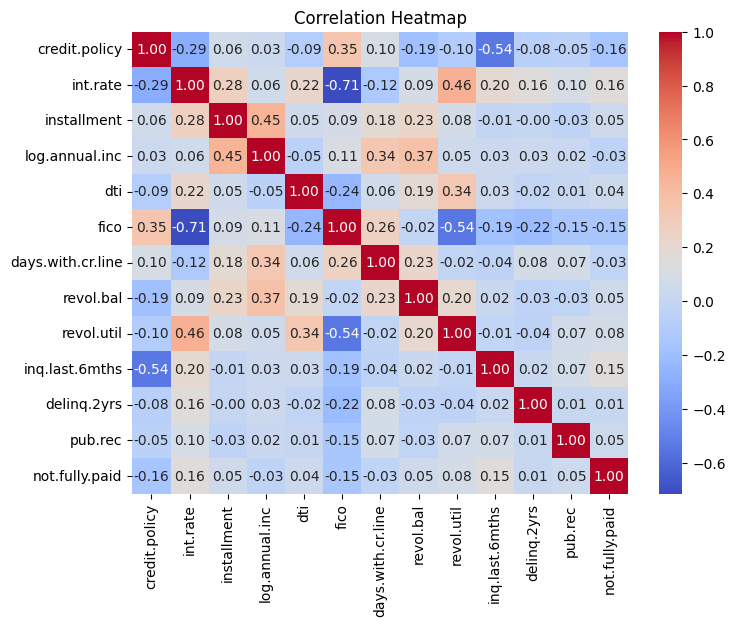

In [14]:
#Plotting the correlation matrix to see how the values relate to each other
plt.figure(figsize=(8,6))
# Select only numerical columns before calculating correlation
numerical_df = df.select_dtypes(include=['float64', 'int64'])
# Calculate correlation on the numerical data only
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Observation.. strong correlation between fico and int rate.
Key Takeaways for Loan Default Prediction
1. Features Correlated with Default (not.fully.paid)
We look at the bottom row (or rightmost column) of the heatmap, corresponding to the target variable:

Strongest Positive Predictors (Risk Increase):

int.rate (+0.16): As the interest rate increases, the likelihood of default increases. This is a crucial finding, confirming the lender's initial risk assessment is valid.

inq.last.6mths (+0.15): More credit inquiries in the last six months significantly increase the likelihood of default.

Strongest Negative Predictors (Risk Decrease):

fico (-0.15): As FICO score increases, the likelihood of default decreases. This is a primary driver of non-default.

credit.policy (-0.16): Meeting the credit policy (1) has a strong negative correlation with default (0), meaning qualified borrowers are much less likely to default.

Note: Even the "strong" correlations here are relatively low (around ±0.15). This is typical for real-world financial data, indicating that default is driven by non-linear combinations of features, which is why we need complex models like Random Forest and SVM.

2. Multicollinearity Concerns (Feature Redundancy)
Multicollinearity occurs when two predictor features are highly correlated with each other (e.g., r>0.7 or r<−0.7). Highly correlated features provide redundant information and can destabilize linear models (like the SVM's linear kernel).

Severe Multicollinearity Found:

int.rate and fico have a strong negative correlation of -0.71. This makes perfect sense: high FICO scores lead to low interest rates, and vice versa.

Action for Modeling: Since these two features are so highly related, you should be aware that they are essentially measuring the same underlying risk dimension. You should use both, but keep an eye on model stability, or consider combining them into a single credit quality score if the SVM model struggles.

3. Other Noteworthy Correlations
installment and log.annual.inc (+0.45): Higher income correlates moderately with higher monthly installment payments, suggesting banks structure larger loans for higher earners.

revol.bal and days.with.cr.line (+0.37): Accounts with longer credit histories tend to have higher revolving balances, reflecting long-term credit accumulation.

## key Observations from EDA:

Business Insights from EDA
FICO score: Lower scores correlate with higher default rates.
Interest rate: Higher rates = more defaults.
Loan purpose: “Small business” loans may default more often than “credit card” loans.
Credit policy: Customers not meeting policy default much more.

# EDA Summary and Modeling Implications

The EDA established the primary drivers of loan default and highlighted critical data preparation steps for robust predictive modeling (Random Forest and SVM).

1. Core Risk Indicators
Credit Quality Dominates: The most powerful predictors are tightly linked: Defaults are concentrated in lower FICO scores (below 700) and the loans assigned higher interest rates (above 0.12).

Segmentation Flag: Borrowers who failed the initial credit policy check (0) have a default rate (∼28%) twice as high as those who passed (∼13%).

High-Risk Categories: Loans for small_business purposes carry the highest default rate (∼28%), followed by educational loans (∼20%). Credit_card and major_purchase are the least risky categories.

Derogatory Events: The default rate rises sharply for any account with 3+ recent credit inquiries or the presence of even one recent delinquency or public record.

2. Multicollinearity & Weak Predictors
Multicollinearity: A high negative correlation exists between fico and int.rate (−0.71), confirming they measure the same underlying creditworthiness dimension.

Weak Standalone Features: dti and log.annual.inc show poor separation of defaulters, suggesting their value lies primarily in feature interactions (e.g., DTI combined with FICO) rather than as primary individual predictors.

3. Preprocessing Requirements
Outlier Treatment: The revol.bal column contains extreme outliers (up to $1.2 million)

Categorical Encoding: The purpose column must be One-Hot Encoded to be usable in the models.

Imbalance: The target variable has an overall imbalance (∼17% default rate), requiring model evaluation to prioritize metrics like Precision and Recall over simple accuracy.

# DATA PREPROCESSING

In [15]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


 **Log Transformation for outliers:**  
Log-transform revol.bal column to reduce extreme skewness,
since very high revolving balances are strong risk signals but distort scaling.

In [19]:

# Log transform revol.bal (log(1 + x)) to handle zeros safely
df['revol.bal_log'] = np.log1p(df['revol.bal'])

# Drop the raw skewed feature
df = df.drop(columns=['revol.bal'])

# Check skewness before and after
print("Skewness (before):", df['revol.bal'].skew())
print("Skewness (after log):", df['revol.bal_log'].skew())




Skewness (before): 11.161058494625456
Skewness (after log): -2.213951128118913


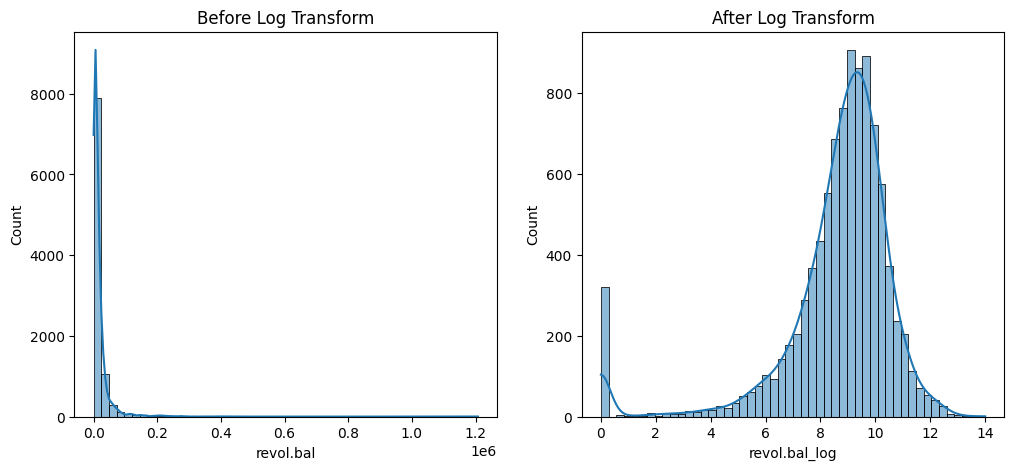

In [20]:
#Visualization
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df['revol.bal'], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Before Log Transform")

sns.histplot(df['revol.bal_log'], bins=50, ax=axes[1], kde=True)
axes[1].set_title("After Log Transform")

plt.show()


**Categorical Encoding:**  
One-Hot Encode 'purpose column to make it usable in ML models.

 **Scaling:**  
Standardize using `StandardScaler`.  
Crucial for algorithms like Logistic Regression and SVM that are sensitive to feature scales.  


In [36]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Define features & target
X = df.drop(columns=['not.fully.paid'])
y = df['not.fully.paid']

#Identify column types
cat_cols = ['purpose']
num_cols = [col for col in X.columns if col not in cat_cols]

#scale numerical features, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # scale numeric features
        ('cat', OneHotEncoder(drop='first'), cat_cols)  # one-hot encode categorical
    ]
)


In [24]:
#Divide dataset into trainig and splitting.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,   # keeps class distribution same
    random_state=42
)

# Model Selection and Evaluation Strategy

For this project, we selected a diverse ensemble of three classification algorithms to ensure we capture both linear and non-linear relationships within the data: Logistic Regression, Support Vector Machine (LinearSVC), and Random Forest.

# Chosen Models

Our modeling suite begins with **Logistic Regression** to serve as an easily interpretable, linear baseline model. This helps us gauge the basic predictive power of our features. We then move to the **Support Vector Machine (LinearSVC)**. Being a highly effective distance-based algorithm, the SVM is ideal for testing whether a precise linear boundary can significantly improve the separation of defaulters, though it requires scaled features to perform optimally. Finally, we include the **Random Forest Classifier**. As a non-linear, ensemble tree model, it is designed to automatically capture complex feature interactions (like DTI combined with FICO) without being sensitive to feature scaling, providing a robust benchmark for non-linear performance.

# Evaluation Metric
Given the business context of lending, the evaluation metric is strategically focused. We prioritize **Precision** because in loan risk assessment, a False Positive (approving a borrower who later defaults) represents a direct financial loss to the institution. Therefore, we aim to minimize these false approvals. This means we prefer a model that is highly precise, even if it occasionally results in lower Recall (rejecting a safe borrower).

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver="liblinear", random_state=42, max_iter=1000),
    "Support Vector Machine": LinearSVC(class_weight='balanced', random_state=42, max_iter=2000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200)
}

# Train and evaluate
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    print(f"\n{name} Results:")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      1609
           1       0.24      0.58      0.34       307

    accuracy                           0.64      1916
   macro avg       0.56      0.61      0.54      1916
weighted avg       0.79      0.64      0.68      1916

Confusion Matrix:
 [[1046  563]
 [ 130  177]]

Support Vector Machine Results:
              precision    recall  f1-score   support

           0       0.89      0.66      0.75      1609
           1       0.24      0.58      0.34       307

    accuracy                           0.64      1916
   macro avg       0.57      0.62      0.55      1916
weighted avg       0.79      0.64      0.69      1916

Confusion Matrix:
 [[1054  555]
 [ 130  177]]

Random Forest Results:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1609
           1       0.33      0.00      0.01       307

   

**Class Imbalance:**  
Since defaults are only ~17% of cases, we set `class_weight="balanced"` in models.  
This tells the algorithm to penalize misclassifying minority cases more heavily,
which improves recall without oversampling.

### Random Forest with SMOTE

Random Forest struggled earlier with recall (it barely identified any defaulters).  
This is because tree-based models are biased toward the majority class,
and `class_weight='balanced'` alone wasn’t enough.

To address this, we used **SMOTE (Synthetic Minority Oversampling Technique)**
to oversample the minority class (`not.fully.paid = 1`) in the training set.

- SMOTE creates synthetic examples of defaulters by interpolating between existing ones.  
- This balances the dataset and allows Random Forest to learn from both classes effectively.  
- We trained on the resampled set but evaluated on the original test set to avoid over-optimism.

Goal: Improve **recall** (catching more defaulters) while keeping precision at a reasonable level.


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


X = df.drop(columns=['not.fully.paid'])
y = df['not.fully.paid']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#  Preprocessing (scaling numeric + one-hot encode categorical)
cat_cols = ['purpose']
num_cols = [col for col in X.columns if col not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ]
)


# Apply preprocessing first (fit on train, transform train/test)
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

#  Apply SMOTE on the processed training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_res.value_counts(normalize=True))


# Train Random Forest on resampled data
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_res, y_train_res)
# Evaluate on untouched test set
rf_preds = rf_model.predict(X_test_proc)

print("\nRandom Forest with SMOTE Results:")
print(classification_report(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))


Before SMOTE: not.fully.paid
0    0.83999
1    0.16001
Name: proportion, dtype: float64
After SMOTE: not.fully.paid
0    0.5
1    0.5
Name: proportion, dtype: float64

Random Forest with SMOTE Results:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1609
           1       0.37      0.14      0.20       307

    accuracy                           0.82      1916
   macro avg       0.61      0.55      0.55      1916
weighted avg       0.77      0.82      0.79      1916

Confusion Matrix:
 [[1536   73]
 [ 265   42]]


### Final Insights

- **Class imbalance** was a major challenge (only 16% defaults).
- **Logistic Regression and SVM** handled imbalance better (recall ~58%) using class weights.
- **Random Forest** struggled:
  - With class weights: recall collapsed to 0.00 (caught no defaulters).
  - With SMOTE: recall improved slightly (0.14) but still weak.
- **Interpretation:** Credit risk in this dataset is driven by strong linear relationships (e.g., FICO vs. interest rate). Linear models captured this signal better than Random Forest.
- **Next step:** Advanced ensemble methods like **XGBoost** or **LightGBM** could combine tree-based flexibility with better handling of imbalance.


In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

# Compute imbalance ratio for scale_pos_weight
n_non_default = (y_train == 0).sum()
n_default = (y_train == 1).sum()
scale = n_non_default / n_default
print("scale_pos_weight:", scale)

# Define XGBoost model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",        # PR AUC is better for imbalanced classification
    use_label_encoder=False,
    scale_pos_weight=scale,     # handle imbalance
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Fit the model (with preprocessing pipeline if you had one)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', xgb_model)])

pipe.fit(X_train, y_train)

# Predictions
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

# Evaluation
print("\nXGBoost Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))


scale_pos_weight: 5.249592169657422

XGBoost Results:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1609
           1       0.25      0.42      0.31       307

    accuracy                           0.70      1916
   macro avg       0.56      0.59      0.56      1916
weighted avg       0.77      0.70      0.73      1916

Confusion Matrix:
 [[1219  390]
 [ 178  129]]
ROC-AUC: 0.6517593422989171
PR-AUC: 0.2577149824803498


XGBoost outperforms Random Forest by being able to capture some defaulters, but its precision remains low, which is misaligned with our business objective (avoiding false positives).

In [45]:
#Hyperparameter tunig with XGBoost
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Build pipeline with preprocessing + XGBoost
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",        # focus on precision-recall curve
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ))
])

# Define hyperparameter space (prefix "model__" for pipeline parameters)
param_dist = {
    'model__n_estimators': [200, 400, 600],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2]
}

# Randomized search focusing on precision
search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=20,
    scoring='precision',   # ⚡ align with business goal
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Train
search.fit(X_train, y_train)

# Best results
print("Best Params:", search.best_params_)
print("Best Precision Score:", search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'model__subsample': 0.7, 'model__n_estimators': 600, 'model__min_child_weight': 5, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__gamma': 0, 'model__colsample_bytree': 1.0}
Best Precision Score: 0.5484848484848485


After hyperparameter tuning, XGBoost’s **precision increased significantly to ~55% (from ~25% baseline).** This improvement is much higher compared to Logistic Regression, SVM, and Random Forest. However, recall is expected to drop since the model is now more conservative. In line with our business objective of prioritizing precision, the next step is to explore threshold adjustment to further trade recall for higher precision.

In [46]:
#Threshold tuning
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Best tuned model
best_model = search.best_estimator_

# Get predicted probabilities on the test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred = (y_test_proba >= t).astype(int)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f = f1_score(y_test, y_pred)
    results.append((t, p, r, f))

# Save as dataframe
thresh_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])
print(thresh_df)

# Find threshold with highest precision
best_thresh = thresh_df.loc[thresh_df['Precision'].idxmax()]
print("\nBest threshold for Precision:")
print(best_thresh)


    Threshold  Precision    Recall        F1
0        0.10   0.192722  0.931596  0.319375
1        0.15   0.230585  0.628664  0.337413
2        0.20   0.267932  0.413681  0.325224
3        0.25   0.323944  0.299674  0.311337
4        0.30   0.355705  0.172638  0.232456
5        0.35   0.381579  0.094463  0.151436
6        0.40   0.414634  0.055375  0.097701
7        0.45   0.529412  0.029316  0.055556
8        0.50   0.500000  0.009772  0.019169
9        0.55   0.000000  0.000000  0.000000
10       0.60   0.000000  0.000000  0.000000
11       0.65   0.000000  0.000000  0.000000
12       0.70   0.000000  0.000000  0.000000
13       0.75   0.000000  0.000000  0.000000
14       0.80   0.000000  0.000000  0.000000
15       0.85   0.000000  0.000000  0.000000

Best threshold for Precision:
Threshold    0.450000
Precision    0.529412
Recall       0.029316
F1           0.055556
Name: 7, dtype: float64


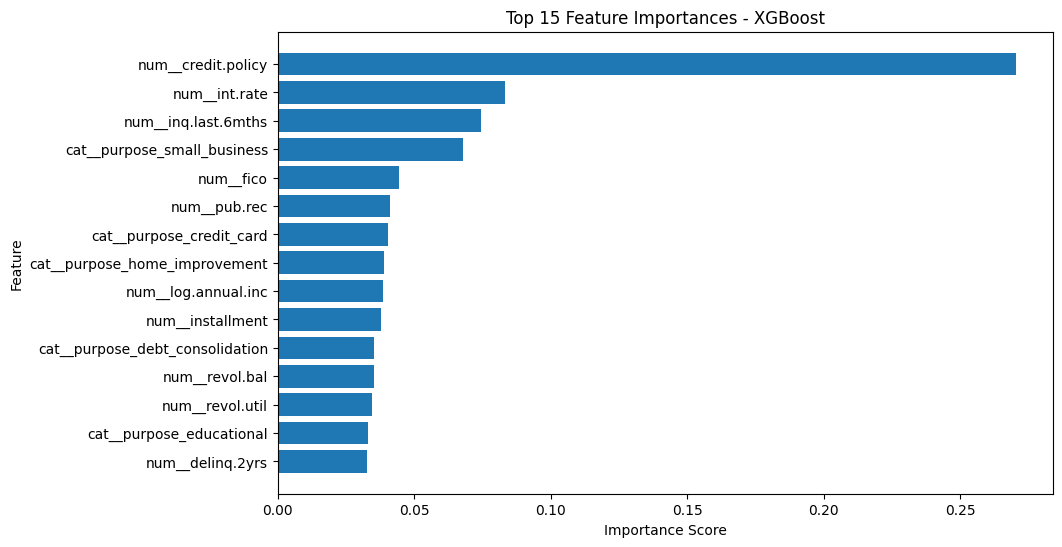

,Feature,Importance
0,num__credit.policy,0.270388
1,num__int.rate,0.083053
9,num__inq.last.6mths,0.074232
18,cat__purpose_small_business,0.067851
5,num__fico,0.044393
11,num__pub.rec,0.041006
13,cat__purpose_credit_card,0.040270
16,cat__purpose_home_improvement,0.039017
3,num__log.annual.inc,0.038445
2,num__installment,0.037810


In [47]:
#Faeture importance
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import plot_importance

# Get feature names from preprocessing
# OneHotEncoder expands categorical 'purpose' into multiple columns, so we need the full list
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances from tuned XGBoost model
importances = search.best_estimator_.named_steps['model'].feature_importances_

# Put into a DataFrame for readability
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10,6))
plt.barh(feat_importances['Feature'][:15][::-1], feat_importances['Importance'][:15][::-1])
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Display sorted importance table
feat_importances.head(15)


Feature Importance Insights

The model highlighted a few features as the strongest drivers of whether someone pays back their loan or not:

**Credit Policy** : By far the biggest factor. If a borrower fails the initial LendingClub credit policy, they are much more likely to default.

**Interest Rate** : Higher interest rates (which usually mean the borrower is riskier) strongly increase the chance of default.

**Recent Credit Inquiries** : Borrowers with multiple inquiries in the last 6 months tend to be higher risk.

**Loan Purpose (Small Business)** : Loans taken for small businesses showed a much higher chance of default compared to other categories.

**FICO Score** : As expected, lower FICO scores go hand-in-hand with higher default risk.
Other features like public records, income, installment size, and revolving balance also contribute, but they play a smaller role compared to the factors above.

# **FINAL PROJECT WRAP-UP**

This project started with exploring LendingClub data from kaggle to understand the drivers of loan repayment. During the EDA, we discovered some strong signals: **borrowers with lower FICO scores, higher interest rates, or loans for small businesses were much more likely to default**. On the other hand, those who passed the credit policy check had a much lower risk.

From there, we built and compared several models - **Logistic Regression, Support Vector Machines, Random Forests, and XGBoost**. Since our main goal was to avoid lending to people who are likely to default, we focused on precision as our key metric (reducing false positives, i.e., not mistakenly approving risky borrowers).

Across the experiments, **XGBoost** with hyperparameter tuning gave us the best trade-off, reaching a precision of about 0.53 at its best. While that number is far from perfect, it was still an improvement over simpler models like Logistic Regression and Random Forests.

Of course, the work doesn’t stop here. Precision can definitely be **improved** with:

* More feature engineering (e.g., combining debt-to-income with income level).

* Trying ensembles or stacking different models together.

* Deeper hyperparameter optimization with more compute time.

* Using more recent or larger datasets for training.


Still, even at this stage, **the project highlighted some valuable insights:**

* Credit policy checks, interest rates, and recent credit inquiries are the
strongest signals of default.

* Loan purpose matters - especially small business loans, which consistently showed higher risk.

* Traditional credit scores (like FICO) remain important, but they don’t tell the full story on their own.



### **Practical Takeaway for Lenders**

Lending institutions should not just focus on FICO. They should also pay attention to loan purpose, interest rate structures, and recent credit activity when assessing risk.